In [1]:
"""
Created on Mon 20 Nov 2017.

Walk through the paper:
Personalized Risk Scoring for Critical Care Prognosis using Mixtures of Gaussian Processes

Preparation for the Reading Group 27 Nov 2017

@author: mpimentel
"""

import numpy as np
import pandas as pd
from time import time
import sys 

import matplotlib
import matplotlib.pylab as plt
import seaborn as sns

from IPython.display import Image

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# machine learning libraries
import gpflow

# metrics
from sklearn.metrics import roc_auc_score, average_precision_score

In [2]:
%matplotlib inline

sns.set_style("dark")

# Reading Group
## Personalized Risk Scoring for Critical Care Prognosis using Mixtures of Gaussian Processes

Marco AF Pimentel

27 November 2017

<sub> http://gitlab.com/mpimentel/readinggroups </sub>

<img src="http://www.supercoloring.com/sites/default/files/silhouettes/2015/05/oxford-skyline-black-silhouette.svg" width=5012>

## Authors

<center>
<img src="http://freelogo2016cdn.b-cdn.net/wp-content/uploads/2016/12/UCLA_Logo_University_of_California_Los_Angeles.png" width=128 align="middle">
</center>

- Ahmed M. Alaa, Machine Learning 
- Yoon Jinsung, Machine Learning
- Scott Hu, MD
- Michaela van der Schaar

## Introduction

### An overview of the paper

<center>
<img src="img/WC_RG_27112017.png" width=1000 align="middle">
<sub> (Created using www.worldclouds.com) <sub>
</center>

### The problem

- More than 200,000 hospitalized patients have cardiac arrests each year in the US

- 75% of those die

- Many of those cardiac arrests could be prevented, as unanticipated events **are often preceded** by disorder in a patient's physiological parameters

- Current risk scores provide only modest contributions to clinical outcomes
    - use a small subset of the available EHR data
    - "one-size-fits-all" approach (not personalized)
    - modelling approach for dealing with different types of the data

### The goal

- To develop a risk scoring algorithm that provides personalized assessments for the acuity of critical care patients in a hospital ward

## Challenges

## Related Works

Risk scoring systems (these are typically _used and built for different purposes_):

- **Expert-based** scoring systems (Early warning score, EWS)

- **Regression-based** methods (e.g., APACHE and other recent logistic regression-based approaches)

- Approaches that use **Gaussian process** regression

- Methods based on **survival analysis** (Cox regression-based model)

- A few _personalized_ risk prognosis models

## The physiological model

**Physiological information**
- D sparse variables acquired over time with the following properties:

    1) variables can be measured at different times

    2) one variable can be measured more often than the other
    
$$X(t) = [X_1(t),X_2(t),...,X_D(t)]^T$$

Specifically, for one patient we have the following physiological information:

$$[X_i(t_{ij})]_{i=1,j=1}^{D,M_i}, [x_{ij}, t_{ij}]_{ij}$$

where $i = 1,...,D$ variables, and $j = 1,...,M_i$ samples for variable $i$.

**Admission information**
- patient's static information (age, gender, admission diagnoses, etc)
$$Y=y$$

**Clinical status**
- what we are trying to predict:

$$ V = \begin{cases} 
0 &\text{clinically stable} \\
1 &\text{clinically deteriorating}
\end{cases}$$

- at a certain time $t$, a patient's risk score $R(t)$ is estimated:

$$ \bar{R}(t) = \mathbb{P}(V=1 | y, [x_{ij}, t_{ij} \leq t ]_{ij}) $$


### The model

<center>
<img src="img/graphical_model_before.png" height=800 align="middle">
</center>

### The model

<center>
<img src="img/graphical_model.png" height=1000 align="middle">
</center>

#### Modelling the physiological signals

- D phsyiological streams modelled as a multitask Gaussian process (GP)

- Hyperparameters depend on the patient's latent clinical status $V$

- Stable and deteriorating patients modelled differently

    1) Stable patients do not exhibit changes in their clinical status => stationary model
    
    2) Deteriorating patients pass through phases of clinical acuity => non-stationary model

# Let's divert from the paper for "9 minutes"
## (simply to address a couple of notions)

##### Challenges of GP inference (nowadays)

**Scalling**
- GP in general requires $\mathcal{O}(N^3)$ computation.

- e.g., Hensman et al. Gaussian processes for big data. UAI 2013.
 
**Non-conjugate likelihoods**
- Inference is only analytically tractable for the Gaussian likelihood.

- Use of integrated approximation.

A Gaussian process can be described as a ***distribution over functions***, which is fully specified by a mean *function* and a covariance *function*:

$$p(x) \sim \mathcal{GP}(m(t), k(t,t^{\prime}))$$

For example, one specification of a GP might be as follows:

$$\begin{aligned}
m(t) &=\theta_0 \\
k(t,t^{\prime}) &= \theta_1\exp\left(-\frac{\theta_2}{2}(t-t^{\prime})^2\right)
\end{aligned}$$

here, the covariance function is a **squared exponential**, where typically $\theta_1 = \omega_0^2$ and $\theta_2 = \frac{1}{\mathcal{l}_0^2}$.

- To make these idea of **distribution over functions** more concrete, let's quickly demonstrate how we obtain realizations from a Gaussian process!

- First, realizations of a **Gaussian distribution**, mean = 0, variance = 1:

    - That's easy: >> *randn*

In [45]:
np.random.seed(42)
x1 = np.random.normal(scale = 1, loc = 0, size = 50000)

In [84]:
# generate one data point from the Gaussian distribution
x = [np.random.normal(scale = 1, loc = 0, size = 1)]
np.ones(len(x))

array([ 1.])

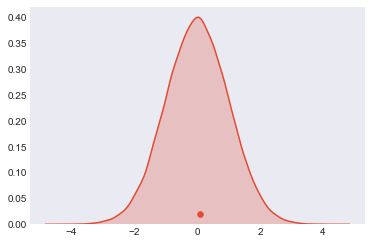

In [47]:
# set y to a certain height for visualisation purposes
sns.kdeplot(x1, shade=True) # simply for reference
plt.scatter(x,0.02*(np.ones(len(x))))

In [106]:
# generate another data point
x.append(np.random.normal(scale = 1, loc = 0, size = 1))

sns.kdeplot(x1, shade=True) # simply for reference
#plt.scatter(x,0.02*(np.ones(len(x))), marker = "|")
sns.distplot(x, kde=True, rug=True, bins=20)
plt.ylim(0,0.51)

(0, 0.51)


It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed. 

For example, one specification of a GP might be as follows:

$$\begin{aligned}
m(x) &=0 \\
k(x,x^{\prime}) &= \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)
\end{aligned}$$

here, the covariance function is a **squared exponential**,

In [ ]:
%run utils/get_data.py
sns.regplot(x, y, fit_reg=False)

In [ ]:
data = pd.read_csv('utils/day.csv', header=0)
data.head()

In [ ]:
#sns.regplot(data['instant'], data['temp'], fit_reg=False)
sns.regplot(data['instant'][1:50], data['hum'][1:50], fit_reg=True)

##  Thanks

In [ ]:
print('Thanks')